In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools
import math

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(utils_jjm)

<module 'python_utils_jjm' from '/home/jma819/post_cmfe_analysis/python_utils_jjm.py'>

In [3]:
cnmfe_file_key = pd.read_csv('/projects/p30771/dlc_analysis/openfield_dlc_output/cnmfe_file_key.csv')

In [4]:
cnmfe_base_dir = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat', '29-Mar_13_39_44_out.mat']
#issues: '13-Apr_16_11_27_out.mat'
#issues: H17_M32_S17

In [5]:
tracking_files = ['/projects/p30771/dlc_analysis/openfield_dlc_output/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in ko_CNMFE_files] 

In [6]:
#tracking_files

In [7]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in ko_CNMFE_files]
#CNMFE_dir_paths_list

In [8]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

spatial_components_by_session = {}
group_results_binning = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # create time deltas
        C_z_scored, interpolated = utils_jjm.prepare_timedelta_dfs(CNMFE_file, tracking_file)
        # downsample and bin
        cells_C_binned_by_V, cells_mean_C_binned_by_V = dlc_utils.downsample_session_and_bin_C_by_V(binning_time, number_of_bins, body_part_for_tracking, interpolated, C_z_scored)
        # add save step here?
        group_results_binning[tracking_file.split('/')[-2]] = {'C_z_scored':C_z_scored, 'tracking_data' :interpolated, 
                                              'C_binned_by_V':cells_C_binned_by_V, 'C_binned_by_V_means':cells_mean_C_binned_by_V}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
        
        #load spatial components by session
        com_df, spatial_components = utils_jjm.return_spatial_info(CNMFE_file, 0.6)
        spatial_components_by_session[tracking_file.split('/')[-2]] = {'com' : com_df, 'spatial_components' : spatial_components}
    
    except FileNotFoundError:
        failed.append(tracking_file)
    except OSError:
        failed.append(tracking_file)

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rco

In [ ]:
regression_results_by_group = {}
for tracking_file in list(group_results_binning.keys()):
    # add regression results
    regression_results = dlc_utils.create_regression_models_per_cell(group_results_binning[tracking_file]['C_binned_by_V_means'], polynomial_degree)
    regression_results_by_group[tracking_file] = regression_results

#session_names = [session_name.split('/')[-2] for session_name in list(group_results_binning.keys())]    
session_names = list(group_results_binning.keys())

## get some summaries of regression info by groups
grouped_info = {}
grouped_info_means = {}
for session in list(group_results_binning.keys()):
    info_by_session = {}
    info_by_session_means = {}
    session_results = regression_results_by_group[session]
    # F statistics
    F_stats_by_session = np.array([float(session_results[cell]['statsmodel_results'].summary().tables[0][3][3].data) 
                    for cell in range(1, len(session_results)+1)])
    info_by_session['F_stats'] = F_stats_by_session
    info_by_session_means['total_cells'] = len(F_stats_by_session)
    # r2
    r_stats_by_session = np.array([float(session_results[cell]['statsmodel_results'].summary().tables[0][3][3].data) 
                    for cell in range(1, len(session_results)+1)])
    info_by_session['R-squared'] = r_stats_by_session
    info_by_session_means['R-squared_mean'] = np.mean(r_stats_by_session)
    # significant regressions
    significant_regressions = len(np.argwhere(F_stats_by_session<0.05))
    info_by_session_means['significant_regressions'] = significant_regressions 
    
    #proportion of significant regressions 
    percent_significant = (significant_regressions/len(F_stats_by_session))*100
    info_by_session_means['percent_significant'] = percent_significant
    #print('percent significant')
    #print(percent_significant)
    grouped_info[session] = info_by_session
    grouped_info_means[session] = info_by_session_means
    
grouped_info_means = pd.DataFrame(grouped_info_means)
grouped_info = pd.DataFrame(grouped_info_means)

In [ ]:
failed

In [ ]:
grouped_info_means

In [ ]:
grouped_info_means.mean(axis=1)

In [ ]:
plt.scatter(np.ones(len(grouped_info_means.loc['percent_significant'].values)), grouped_info_means.loc['percent_significant'].values)

In [ ]:
#grouped_info_means.loc['R-squared_mean']
plt.scatter(np.ones(len(grouped_info_means.loc['R-squared_mean'].values)), grouped_info_means.loc['R-squared_mean'].values)

# triggered averaging 

In [9]:
avged_by_session = {}
for session in list(group_results_binning.keys()):
    print(session)
    # downsample velocity and pick maximum values within 200msec 
    new_sampling_interval = 2
    interpolated = group_results_binning[session]['tracking_data'].set_index(pd.to_timedelta(np.linspace(0, len(group_results_binning[session]['tracking_data'])*(1/20), 
                                                                                                len(group_results_binning[session]['tracking_data'])), unit='s'), drop=True)
    interpolated_downsampled = interpolated.resample(str(new_sampling_interval)+'S').max()
    # bin by activity threshold (body_part, resting_time_threshold, active_time_threshold, resting_threshold, activity_threshold)
    binned_velocity = dlc_utils.bin_by_activity_threshold(interpolated['tail_base'], 40, 20, 0.5, 0.5)
    transition_indicies = utils_jjm.select_trigger_regions(binned_velocity, 0.5, 0.5, 40)
    
    ##aligning to fluorescence trace
    C_z_scored_session_input = group_results_binning[session]['C_z_scored']
    #filter out small cells
    cell_contours, x, y, cell_dims = utils_jjm.create_contour_layouts(spatial_components_by_session[session]['spatial_components'])
    C_z_scored_session = utils_jjm.filter_out_by_size(C_z_scored_session_input, cell_contours, cell_dims, 0.6, 100)

    #if using normed df
    #df_for_averaging = C_z_scored_session.apply(utils_jjm.normalize)
    df_for_averaging = C_z_scored_session
    threshold_regions_df = utils_jjm.average_triggered_regions(df_for_averaging, transition_indicies, 40) 
    relative_triggered_df = utils_jjm.adjust_triggered_average_plots(binned_velocity, df_for_averaging, threshold_regions_df)
    avged_by_session[session] = relative_triggered_df 

GRIN009_H13_M59_S14
GRIN018_H17_M41_S43
GRIN018_H16_M13_S53
GRIN011_H10_M19_S59
GRIN012_H16_M57_S23


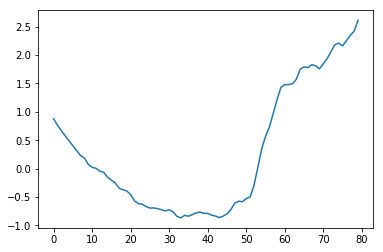

In [20]:
plt.plot(avged_by_session[list(avged_by_session.keys())[4]].mean(axis=1))
plt.show()

In [11]:
#concat by mouse 
concacted = {}
for mouse in list(set([session[0:7] for session in list(avged_by_session.keys())])):
    dfs_by_mouse = []
    for session in list(avged_by_session.keys()):
        if mouse in session:
            dfs_by_mouse.append(avged_by_session[session].mean(axis=1))
    concacted[mouse] = pd.DataFrame(np.transpose(dfs_by_mouse)).mean(axis=1)
by_mouse_df = pd.DataFrame(concacted)

In [12]:
std_error = (by_mouse_df.std(axis=1)/math.sqrt(len(by_mouse_df))).values
mean = by_mouse_df.mean(axis=1)
x = np.linspace(-2, 2, 80)

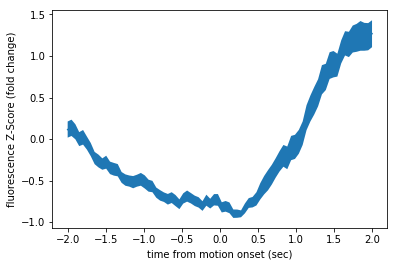

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(x, mean)
plt.fill_between(x,mean-std_error, mean+std_error)
ax = plt.gca()
ax.set_ylabel('fluorescence Z-Score (fold change)')
ax.set_xlabel('time from motion onset (sec)')
plt.show()
plt.draw()
plt.savefig('/home/jma819/presentation_files/ko_triggered_average.svg', transparent=True, format="svg")


## for group spatial clustering

In [ ]:
#get spatial components by group
spatial_components_by_session = {}
for cnmfe_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    com_df, spatial_components = utils_jjm.return_spatial_info(cnmfe_file, 0.6)
    spatial_components_by_session[tracking_file.split('/')[-2]] = {'com' : com_df, 'spatial_components' : spatial_components}
    

In [ ]:
spatial_components_by_session.keys()

In [ ]:
#spatial_components_by_session['GRIN013_H13_M33_S54']['com']
#group_results_binning['GRIN013_H13_M33_S54']['C_z_scored']

In [ ]:
## clustering across session
clustering_info = {}
fluoresence_bin_width = 20
Z_score_threshold = 3
for recording_session in list(spatial_components_by_session.keys()):
    #pairwise_distance
    pairwise_distance = utils_jjm.get_pairwise_distance_by_session(spatial_components_by_session[recording_session]['com'])
    #binned fluorescence
    C_z_scored_binned = group_results_binning[recording_session]['C_z_scored'].apply(utils_jjm.binning_function_uncrop, args=[fluoresence_bin_width, Z_score_threshold])
    C_z_scored_binned.drop(['msCamFrame'], axis=1, inplace=True)
    # get linear pairwise correlation coefficients
    pairwise_pearson = utils_jjm.get_linear_pairwise_correlation_coefficients(C_z_scored_binned, spatial_components_by_session[recording_session]['com'])
    clustering_info[recording_session] = {'pairwise_distance' : pairwise_distance, 'C_z_scored_binned' : C_z_scored_binned, 'pairwise_pearson' : pairwise_pearson}

In [ ]:
#clustering_info[list(spatial_components_by_session.keys())[0]]['pairwise_distance']

In [ ]:
#clustering_info['GRIN034_H15_M28_S2']['pairwise_pearson']

In [ ]:
session = 7
plt.scatter(clustering_info[list(spatial_components_by_session.keys())[session]]['pairwise_distance'].values, 
         clustering_info[list(spatial_components_by_session.keys())[session]]['pairwise_pearson'].values)
plt.show()

In [ ]:
#clustering_info[list(spatial_components_by_session.keys())[0]]['pairwise_distance']

In [ ]:
#clustering_info[list(spatial_components_by_session.keys())[0]]['pairwise_distance'].values[0]

In [ ]:
#run regressions
regressions_by_session = {}
for cnmfe_file in list(spatial_components_by_session.keys()):
    try:
        regressions_by_session[cnmfe_file] = utils_jjm.store_regression_info_per_session(clustering_info[cnmfe_file]['pairwise_pearson'].values[0], 
                                                                                         clustering_info[cnmfe_file]['pairwise_distance'].values[0], 2)
        #print(cnmfe_file)
    except ValueError:
        pass

In [ ]:
trendlines = pd.DataFrame(np.transpose([regressions_by_session[session]['p1d'](np.linspace(0, 400, 400)) for session in regressions_by_session.keys()]), 
             columns=regressions_by_session.keys())

In [ ]:
plt.plot(trendlines.mean(axis=1))
plt.show()

In [ ]:
#clustering during rest or movement
clustering_by_v = {}
velocity_threshold = 2
for cnmfe_file in list(spatial_components_by_session.keys()):
    indicies_to_match = interpolated.iloc[0:len(C_z_scored_binned)][interpolated.iloc[0:len(C_z_scored_binned)]['centroid']>velocity_threshold].index
    C_z_scored_by_v = clustering_info[cnmfe_file.split('/')[-2]]['C_z_scored_binned'].iloc[[interpolated.index.get_loc(value) for value in indicies_to_match]]
    pairwise_pearson = utils_jjm.get_linear_pairwise_correlation_coefficients(C_z_scored_by_v, spatial_components_by_session[cnmfe_file.split('/')[-2]])
    clustering_by_v[spatial_components_by_session[cnmfe_file.split('/')[-2]]] = pairwise_pearson